In [2]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

# **Reading in the data**

In [1]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
import itertools
import networkx.algorithms.community as nx_comm
from networkx.algorithms import bipartite
import re
import csv
from fa2 import ForceAtlas2
import community


folder = "../Movie Dataframe with Ratings/"
df1 = pd.read_pickle(folder+"networkData1.pkl")
df2 = pd.read_pickle(folder+"networkData2.pkl")
df3 = pd.read_pickle(folder+"networkData3.pkl")

frames = [df1, df2, df3]
moviesDf = pd.concat(frames, axis=0, ignore_index=True)


In [3]:
actor_column = list(moviesDf["Actors"].to_numpy())
actors = [actor for cast in actor_column for actor in cast]
duplicates = set(actors) & set(moviesDf["MovieTitle"].to_numpy())
duplicates

# Removing movies where an Actor is called the same
moviesDf.drop(moviesDf[moviesDf['MovieTitle'].isin(duplicates)].index, inplace = True)

**Extracting relevant columns**

In [4]:
genres = (moviesDf['Genres'].to_numpy())
rating_column = moviesDf['Rating'].to_numpy()
genre_column = [re.findall(r"'name': '(.*?)'}", s) for s in genres]
title_column = moviesDf["MovieTitle"].to_numpy()
actor_column = list(moviesDf["Actors"].to_numpy())


#Only using 5 actors
#actor_column5 = []
#for actors in (actor_column):
#    actor_column5.append(actors[:5])
#actor_column = actor_column5
    
actorsDistinct = [*set([actor for cast in actor_column for actor in cast])]

In [5]:
for i,genre in enumerate(genre_column):
    try:
        genre[0]
    except:
        genre_column[i] = ['No genre']

# Creating the graph

**Generating the bipartite network of Actors and Movies**

In [6]:
G = nx.Graph()

#G.add_nodes_from(title_column, bipartite=0)
for i, title in enumerate((title_column)):
    G.add_node(title, bipartite=0, Genre = genre_column[i][0])
    
G.add_nodes_from(actorsDistinct, bipartite=1)


for i, movie in enumerate(title_column):
    # Adding links between each movie and its actors
    G.add_edges_from(list(zip(itertools.repeat(movie), actor_column[i])))

In [7]:
bipartite.is_bipartite(G)

True

**Basic stats**

In [8]:
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

Nodes: 137704
Edges: 255020



**Extracting the projected Actor Network and the Movie Network from the biparite graph**

In [9]:
actorNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
movieNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}

actorNetwork = bipartite.weighted_projected_graph(G, actorNodes, ratio = False)
movieNetwork = bipartite.weighted_projected_graph(G, movieNodes, ratio = False)

In [10]:
print(f'Actor network stats')
print(f'Nodes: {actorNetwork.number_of_nodes()}')
print(f'Edges: {actorNetwork.number_of_edges()}\n')

print(f'Movie network stats')
print(f'Nodes: {movieNetwork.number_of_nodes()}')
print(f'Edges: {movieNetwork.number_of_edges()}\n')

Actor network stats
Nodes: 131746
Edges: 8086719

Movie network stats
Nodes: 5958
Edges: 468645



# Testing stuff

In [11]:
movieEdges = sorted(nx.get_edge_attributes(movieNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)
actorEdges = sorted(nx.get_edge_attributes(actorNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)

In [12]:
movieDegrees = sorted(movieNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorDegrees = sorted(actorNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)

movieDegrees

[('Around the World in Eighty Days', 3528),
 ('Calamity Jane', 1677),
 ('Mighty Joe Young', 1664),
 ('4 for Texas', 1504),
 ('Gentlemen Prefer Blondes', 1497),
 ('My Man Godfrey', 1490),
 ('The Band Wagon', 1437),
 ('Giant', 1419),
 ('Designing Woman', 1413),
 ('Titanic', 1326),
 ('Witness for the Prosecution', 1321),
 ('North by Northwest', 1299),
 ('Pocketful of Miracles', 1297),
 ("Ocean's Eleven", 1288),
 ('The Manchurian Candidate', 1286),
 ('The Great Race', 1279),
 ('The Man Who Shot Liberty Valance', 1242),
 ('The Bad and the Beautiful', 1224),
 ('Inherit the Wind', 1200),
 ('An Affair to Remember', 1191),
 ('Monsieur Verdoux', 1171),
 ('White Christmas', 1169),
 ('A Place in the Sun', 1152),
 ('The Player', 1145),
 ('How to Murder Your Wife', 1124),
 ('Our Man Flint', 1087),
 ('A Night to Remember', 1082),
 ('The Computer Wore Tennis Shoes', 1079),
 ('The Greatest Show on Earth', 1076),
 ('Sabrina', 1041),
 ('Auntie Mame', 1040),
 ('Guys and Dolls', 1025),
 ('Independence Day'

# Extracting backbone of network

In [13]:
from backbone import *

In [14]:
actorAlphaNetwork = disparity_filter(actorNetwork)
movieAlphaNetwork = disparity_filter(movieNetwork)

In [15]:
#alphaActor = 0.1
alphaActor = 0.12
actorNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in actorAlphaNetwork.edges(data=True) if d['alpha'] < alphaActor])
alphaMovie = 0.12
movieNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in movieAlphaNetwork.edges(data=True) if d['alpha'] < alphaMovie])

In [16]:
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'alpha').items(), key=lambda x: x[1], reverse = False)
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'weight').items(), key=lambda x: x[1], reverse = False)

In [17]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 5826
Edges: 23588

Movie network backbone stats
Nodes: 3843
Edges: 13208



In [18]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegreesValues = [val for name, val in actorBackboneDegrees]
movieBackboneDegreesValues = [val for name, val in movieBackboneDegrees]

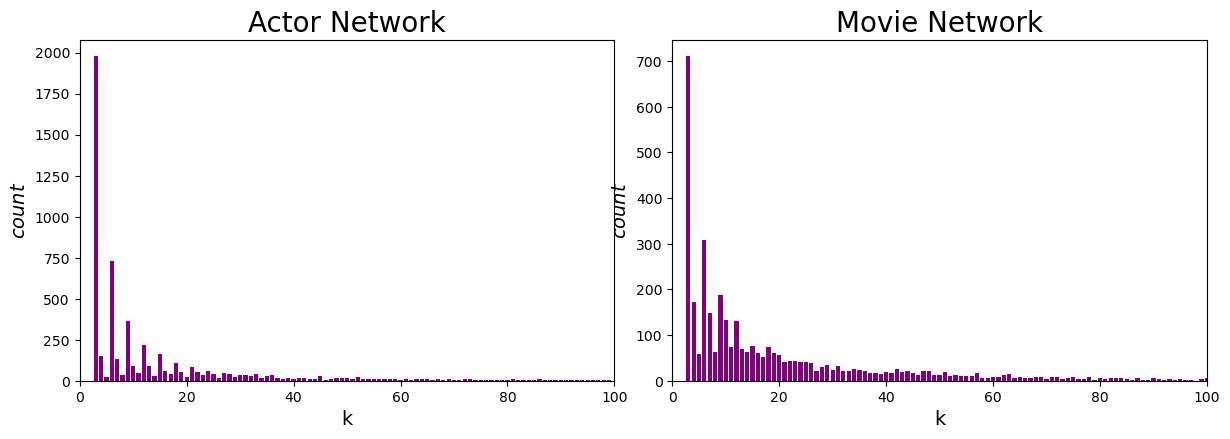

In [19]:
# Binning actors
b = np.arange(np.min(actorBackboneDegreesValues),np.max(actorBackboneDegreesValues),1)
actorFreq, actorBins = np.histogram(actorBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Binning Movies
b = np.arange(np.min(movieBackboneDegreesValues),np.max(movieBackboneDegreesValues),1)
movieFreq, movieBins = np.histogram(movieBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('Actor Network', fontsize = 20)
ax1.set_xlabel('k', fontsize = 14)
ax1.set_ylabel('$count$', fontsize = 14)
ax1.bar(actorBins[:-1], actorFreq, color = 'purple');
ax1.set_xlim(0,100);

ax2.set_title('Movie Network', fontsize = 20)
ax2.set_xlabel('k', fontsize = 14)
ax2.set_ylabel('$count$', fontsize = 14)
ax2.bar(movieBins[:-1], movieFreq, color = 'purple');
ax2.set_xlim(0,100);
plt.show()

# Plotting network Actors

In [20]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(actorNetworkBackbone.degree()).items() if degree < 4]
actorNetworkBackbone.remove_nodes_from(remove)

In [21]:
# Extracting largest connected component
nodes = max(nx.connected_components(actorNetworkBackbone), key=len)
actorNetworkBackbone = actorNetworkBackbone.subgraph(nodes).copy()

In [22]:
positions = forceatlas2.forceatlas2_networkx_layout(actorNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.69it/s]

BarnesHut Approximation  took  3.53  seconds
Repulsion forces  took  3.59  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


In [23]:
d = dict(actorNetworkBackbone.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

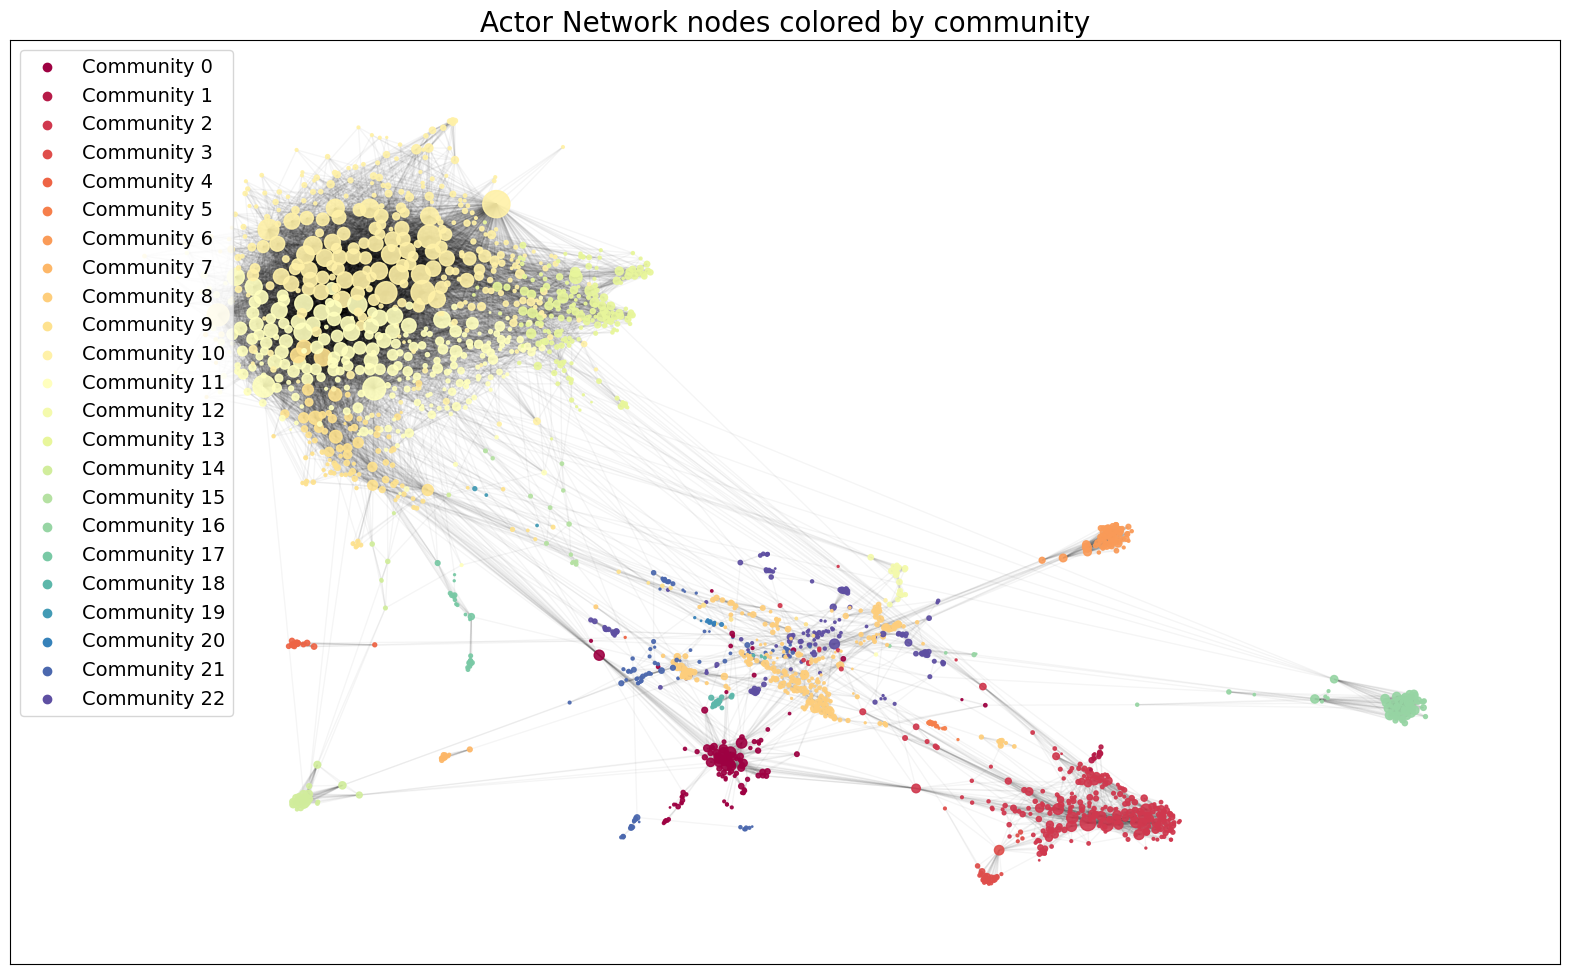

In [24]:
# Best partition found with louvain algorithm
partition = community.best_partition(actorNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
fig = plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(actorNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(actorNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Actor Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('actorNetwork.png')
plt.show()



In [25]:
# rearanging found partition
partsActor = []
for i in range(0, len(set(partition.values()))):
    partsActor.append([])
    
for actor, com in partition.items():
    partsActor[com].append(actor)

#sorting based on biggest communities
partsActorSorted = partsActor
partsActorSorted.sort(key=len, reverse = True)

# Plotting network Movies


In [26]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(movieNetworkBackbone.degree()).items() if degree < 6]
movieNetworkBackbone.remove_nodes_from(remove)

In [27]:
# Extracting largest connected component
nodes = max(nx.connected_components(movieNetworkBackbone), key=len)
movieNetworkBackbone = movieNetworkBackbone.subgraph(nodes).copy()

In [28]:
positions = forceatlas2.forceatlas2_networkx_layout(movieNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.62it/s]

BarnesHut Approximation  took  0.20  seconds
Repulsion forces  took  1.76  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


In [29]:
d = dict(movieNetworkBackbone.degree).values()
scale = 4
node_size = [degree*scale for degree in d]

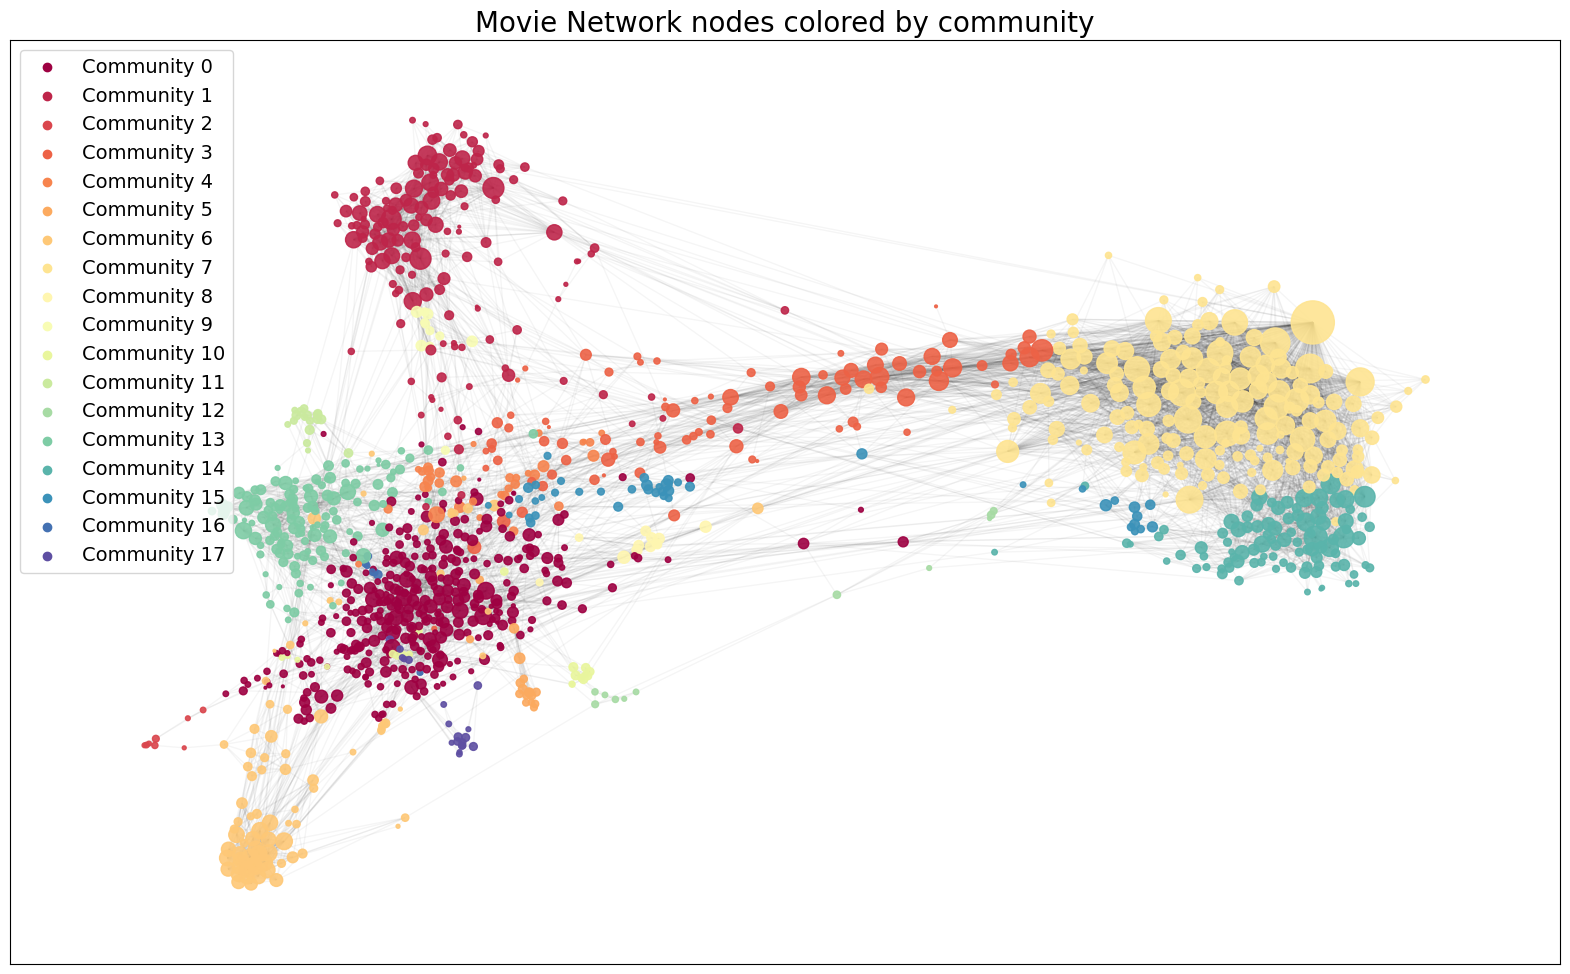

In [30]:
# Best partition found with louvain algorithm
partition = community.best_partition(movieNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(movieNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(movieNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Movie Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('movieNetwork.png')
plt.show()

In [31]:
# rearanging found partition
partsMovie = []
for i in range(0, len(set(partition.values()))):
    partsMovie.append([])
    
for actor, com in partition.items():
    partsMovie[com].append(actor)
    
#sorting based on biggest communities
partsMovieSorted = partsMovie
partsMovieSorted.sort(key=len, reverse = True)

# Analysing found communities

In [32]:
communitySizeActor = [len(com) for com in partsActor]
communitySizeMovie = [len(com) for com in partsMovie]
print(communitySizeActor)
print(communitySizeMovie)

[308, 284, 247, 246, 174, 151, 112, 108, 98, 52, 47, 36, 31, 23, 22, 19, 19, 16, 14, 13, 12, 12, 3]
[357, 178, 145, 129, 94, 92, 83, 43, 35, 20, 19, 18, 17, 13, 11, 11, 8, 8]


In [33]:
for i in partsActor:
    print(i[:5])


['Sam Harris', 'David Ahdar', 'Dan Dowling', 'Norman Stevans', 'Herschel Graham']
['Michael McKean', 'Adam Sandler', 'Phil Hartman', 'Jon Lovitz', 'Selma Archerd']
['Peter Sellers', 'John Adams', 'Irene Handl', 'Harrison Ford', 'Harry Fielder']
['Ralph Moratz', 'John Marlin', 'Fred Rapport', 'Joe Ploski', 'Richard LaMarr']
['Ralph Dunn', 'Lester Dorr', 'Harry Davenport', 'Bert Moorhouse', 'Pat Flaherty']
['Fred Willard', 'Paul McMichael', 'Greg Bronson', 'Chris Ellis', 'Rob Lowe']
['Bob Harks', 'Robert Hitchcock', 'Leoda Richards', 'Clark Ross', 'Benjie Bancroft']
['Frank Welker', 'Robert Clotworthy', 'Peter Renaday', 'Kirk Thornton', 'Michael Lindsay']
['Zaid Farid', 'James Huffman', 'John Cusack', 'Xander Berkeley', 'Fred Ward']
['Willie Garson', 'Allan Graf', 'Peter Jason', 'Andrew Greenbury', 'John Stroehman']
['Larry Miller', 'Tracy Reiner', 'Hector Elizondo', 'Kathleen Marshall', 'Patrick Richwood']
['Fred MacMurray', 'Dennis Hopper', 'Guy Wilkerson', 'Buster Keaton', 'Luree Holm

In [34]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 2047
Edges: 18506

Movie network backbone stats
Nodes: 1281
Edges: 8758



In [35]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)

In [36]:
com = partsMovie[6]
genreAtt = G.nodes(data='Genre')
for movie in com:
    print(f'{movie:<40}{genreAtt[movie]}')

Men at Work                             Comedy
Space Jam                               Animation
The Rugrats Movie                       Animation
An American Tail: Fievel Goes West      Adventure
となりのトトロ                                 Fantasy
Beauty and the Beast                    Romance
The Lion King                           Family
The Rescuers Down Under                 Adventure
Recess: School's Out                    Science Fiction
A Bug's Life                            Adventure
Little Nemo: Adventures In Slumberland  Adventure
The Powerpuff Girls Movie               Animation
Rugrats in Paris: The Movie             Adventure
Anastasia                               Animation
Mulan                                   Animation
The Iron Giant                          Adventure
Lilo & Stitch                           Animation
The Road to El Dorado                   Adventure
The Emperor's New Groove                Adventure
Cats Don't Dance                        Animation
Osmo

In [37]:
#pd.to_pickle(partsActor, 'ActorCommunities.pkl')

# Clustering by genre

In [38]:
movieNodes = list(movieNetworkBackbone.nodes())
movieNodes

['Monkeybone',
 'Showtime',
 'Happy Gilmore',
 'Trixie',
 'Dudley Do-Right',
 'A Guy Thing',
 'A Countess from Hong Kong',
 'Murder at 1600',
 'Stay Tuned',
 "Jumpin' Jack Flash",
 'Armed and Dangerous',
 'The Accused',
 'The Fly II',
 'Disturbing Behavior',
 'The Cable Guy',
 'Zoolander',
 'Mystery Men',
 'The Independent',
 'Gangs of New York',
 'Stuart Saves His Family',
 'Angus',
 'Catch Me If You Can',
 'Magnolia',
 'Men at Work',
 'Full Frontal',
 'Galaxy Quest',
 'Being John Malkovich',
 "Ocean's Eleven",
 'Confessions of a Dangerous Mind',
 'Erin Brockovich',
 'Out of Sight',
 'Traffic',
 '3000 Miles to Graceland',
 'Screwed',
 'Antitrust',
 'Reindeer Games',
 'Romeo Must Die',
 'Stakeout',
 'Orange County',
 'The Princess Diaries',
 'Frankie and Johnny',
 'The Other Sister',
 'Pretty Woman',
 'Nothing in Common',
 'Beaches',
 'The Flamingo Kid',
 'Exit to Eden',
 'Dear God',
 'Runaway Bride',
 'Space Jam',
 'American Pie 2',
 'Roadside Prophets',
 'Timecop',
 'Double Jeopardy'

In [39]:
genreNetwork = G.subgraph(movieNodes).copy()
movieGenre = {movie[0]: movie[1]['Genre'] for movie in genreNetwork.nodes(data=True)}

In [40]:
nx.set_node_attributes(movieNetworkBackbone, movieGenre, name = 'Genre')

In [41]:
set([genre for actor,genre in genreAtt])

genreCommunities = []
for genre in set([genre for actor,genre in genreAtt]):
    genreCommunities.append([node[0] for node in genreNetwork.nodes(data=True) if node[1]['Genre'] == genre])

In [42]:
print(f'Modularity with genre as community: {nx.algorithms.community.modularity(movieNetworkBackbone, genreCommunities)}')
print(f'Modularity with Louvain algorithm: {nx.algorithms.community.modularity(movieNetworkBackbone, partsMovie)}')

Modularity with genre as community: 0.08007319963556536
Modularity with Louvain algorithm: 0.6514457518048723


In [45]:
print(f'Modularity with Louvain algorithm: {nx.algorithms.community.modularity(actorNetworkBackbone, partsActor)}')

Modularity with Louvain algorithm: 0.5644734888403354
